In [1]:
import pandas as pd
import numpy as np
import geopandas
import shapely
from matplotlib import pyplot as plt

In [2]:
name_csv = "checkins_Nebraska.csv"

In [3]:
df = pd.read_csv("./checkins_separated/"+name_csv)


In [4]:
df["time"] = pd.to_datetime(df["datetime"], format="%Y-%m-%dT%H:%M:%SZ")

In [5]:
df["hour"] = df["time"].dt.hour
df["minute"] = df["time"].dt.minute
df["weekday"] = df["time"].dt.weekday
df["timeslot"] = df.apply(lambda x: max(x["hour"]*2-1, 0) if x["minute"] < 30 else x["hour"]+1, axis=1)
df["day"] = df["time"].dt.day_of_year
df["year"] = df["time"].dt.year


In [6]:
df = df.drop_duplicates(subset=["userid", "timeslot", "day"], keep="last").reset_index(drop=True)

In [7]:
df["rank"] = df.groupby("userid")["day"].rank(method="dense", ascending=True)

In [8]:
df["userid"].unique()

array([  1338, 162577, 174066, ...,  56573, 147845, 323425])

In [9]:
# transformar a coluna rank em inteiro
df["rank"] = df["rank"].astype(int)
df

,userid,placeid,datetime,id,created_at,lng,lat,photos_count,checkins_count,users_count,...,index_right,NAME,time,hour,minute,weekday,timeslot,day,year,rank
0,1338,722646,2010-12-24T23:52:54Z,722646,2010-03-16T18:20:30Z,-99.095979,40.713307,0,15,4,...,17.0,Nebraska,2010-12-24 23:52:54,23,52,4,24,358,2010,5
1,1338,722646,2010-04-04T15:59:23Z,722646,2010-03-16T18:20:30Z,-99.095979,40.713307,0,15,4,...,17.0,Nebraska,2010-04-04 15:59:23,15,59,6,16,94,2010,1
2,162577,722646,2010-05-13T19:25:37Z,722646,2010-03-16T18:20:30Z,-99.095979,40.713307,0,15,4,...,17.0,Nebraska,2010-05-13 19:25:37,19,25,3,37,133,2010,22
3,162577,722646,2010-04-18T15:24:05Z,722646,2010-03-16T18:20:30Z,-99.095979,40.713307,0,15,4,...,17.0,Nebraska,2010-04-18 15:24:05,15,24,6,29,108,2010,20
4,162577,722646,2010-04-11T12:30:45Z,722646,2010-03-16T18:20:30Z,-99.095979,40.713307,0,15,4,...,17.0,Nebraska,2010-04-11 12:30:45,12,30,6,13,101,2010,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17197,2117965,6524936,2010-12-02T01:14:12Z,6524936,2010-12-02T01:14:01Z,-96.632487,40.764541,0,1,1,...,17.0,Nebraska,2010-12-02 01:14:12,1,14,3,1,336,2010,14
17198,72367,304191,2010-01-23T23:15:14Z,304191,2009-12-31T21:54:00Z,-97.080045,40.897838,0,3,2,...,17.0,Nebraska,2010-01-23 23:15:14,23,15,5,45,23,2010,3
17199,72367,304191,2009-12-31T21:55:07Z,304191,2009-12-31T21:54:00Z,-97.080045,40.897838,0,3,2,...,17.0,Nebraska,2009-12-31 21:55:07,21,55,3,22,365,2009,6
17200,72367,291189,2009-12-30T20:14:42Z,291189,2009-12-29T19:55:59Z,-96.988667,40.943902,0,2,1,...,17.0,Nebraska,2009-12-30 20:14:42,20,14,2,39,364,2009,5


<Axes: ylabel='Frequency'>

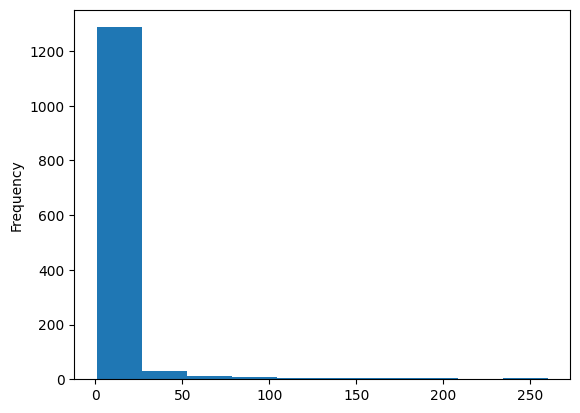

In [10]:
df.groupby("userid")["rank"].max().plot(kind="hist", bins=10)

In [11]:
df["userid"].nunique()


1359

In [12]:
# df_sorted = df. 
# rain = df[df["userid"].isin((df.groupby("userid")["rank"].max().sort_values(ascending=False).reset_index().query("rank >= 15").userid.tolist()))]
# percentil_20
train = df.copy()

In [13]:
gdf = geopandas.GeoDataFrame(train, geometry=geopandas.points_from_xy(x=train.lng, y=train.lat))

<Axes: >

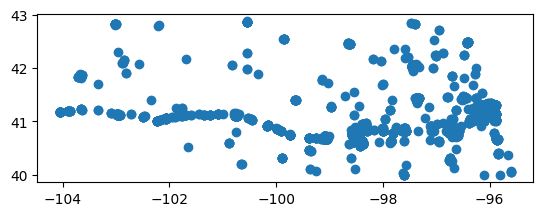

In [14]:


gdf.plot()



In [15]:
xmin, ymin, xmax, ymax= gdf.total_bounds
# how many cells across and down
n_cells=199
cell_size = (xmax-xmin)/n_cells
# projection of the grid
crs = "+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs"
# create the cells in a loop
grid_cells = []
for n1, x0 in enumerate(np.arange(xmin, xmax+cell_size, cell_size)):
    for n2, y0 in enumerate(np.arange(ymin, ymax+cell_size, cell_size)):
        # bounds
        x1 = x0-cell_size
        y1 = y0+cell_size
        grid_cells.append([shapely.geometry.box(x0, y0, x1, y1), n1, n2])
cell = geopandas.GeoDataFrame(grid_cells, columns=['geometry', 'x', 'y'])

In [16]:
cell["id"] = range(len(cell))

(-104.475961283285, -95.178711748415, 39.85685423197, 43.01675388543)

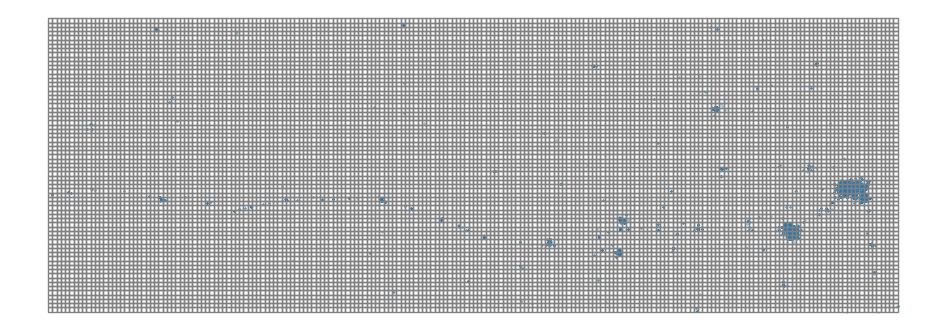

In [17]:
ax = gdf.plot(markersize=.1, figsize=(12, 8))
plt.autoscale(False)
cell.plot(ax=ax, facecolor="none", edgecolor='grey')
ax.axis("off")

In [18]:
cell

,geometry,x,y,id
0,"POLYGON ((-104.09583 40.00049, -104.09583 40.0...",0,0,0
1,"POLYGON ((-104.09583 40.04296, -104.09583 40.0...",0,1,1
2,"POLYGON ((-104.09583 40.08543, -104.09583 40.1...",0,2,2
3,"POLYGON ((-104.09583 40.12790, -104.09583 40.1...",0,3,3
4,"POLYGON ((-104.09583 40.17038, -104.09583 40.2...",0,4,4
...,...,...,...,...
13795,"POLYGON ((-95.64379 42.71873, -95.64379 42.761...",199,64,13795
13796,"POLYGON ((-95.64379 42.76120, -95.64379 42.803...",199,65,13796
13797,"POLYGON ((-95.64379 42.80368, -95.64379 42.846...",199,66,13797
13798,"POLYGON ((-95.64379 42.84615, -95.64379 42.888...",199,67,13798


In [19]:
merged = geopandas.sjoin(gdf.drop(["index_right"], axis=1), cell, how='left', op='within')

/home/alvaro/Documentos/GitHub/LP-BERT/lpbert/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [20]:
train = merged[["userid", "timeslot", "rank", "x", "y"]]
train = train.sort_values(by=['userid','rank', 'timeslot'])
train = train.dropna()


In [21]:
train.rename(columns={'timeslot':'t'}, inplace=True)
train.rename(columns={'rank':'d'}, inplace=True)
train.rename(columns={'userid': 'uid'}, inplace=True)
train

,uid,t,d,x,y
10548,6,2,1,104.0,33.0
10549,6,33,2,193.0,15.0
8962,24,2,1,192.0,29.0
6464,24,33,1,192.0,29.0
4053,24,5,2,192.0,29.0
...,...,...,...,...,...
12870,2669519,1,3,134.0,19.0
11591,2670932,43,1,193.0,23.0
5746,2673730,19,1,190.0,29.0
7390,2673730,1,2,192.0,29.0


In [22]:
train = train.astype(dtype = {'uid': 'int64', 't': 'int64', 'd': 'int64', 'x': 'int64', 'y': 'int64'})
train

,uid,t,d,x,y
10548,6,2,1,104,33
10549,6,33,2,193,15
8962,24,2,1,192,29
6464,24,33,1,192,29
4053,24,5,2,192,29
...,...,...,...,...,...
12870,2669519,1,3,134,19
11591,2670932,43,1,193,23
5746,2673730,19,1,190,29
7390,2673730,1,2,192,29


In [23]:
quartis = train.quantile([0.25, 0.5, 0.75])
quartis['d']
# first_quartil = quartis.loc[0.25, 'd']
# first_quartil

0.25     4.0
0.50    21.0
0.75    67.0
Name: d, dtype: float64

In [24]:
df_sorted = train.sort_values(by=['uid', 'd', 't'])
df_train = df_sorted[df_sorted['d'] <= 20]
df_test = df_sorted[df_sorted['d'] > 20]
df_train


,uid,t,d,x,y
10548,6,2,1,104,33
10549,6,33,2,193,15
8962,24,2,1,192,29
6464,24,33,1,192,29
4053,24,5,2,192,29
...,...,...,...,...,...
12870,2669519,1,3,134,19
11591,2670932,43,1,193,23
5746,2673730,19,1,190,29
7390,2673730,1,2,192,29


In [25]:
train_csv = "train/train_" + name_csv
test_csv = "test/test_" + name_csv


In [26]:
df_train.to_csv(train_csv, index=False)
df_test.to_csv(test_csv, index=False)